In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Modelos y Métricas
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report, roc_auc_score, RocCurveDisplay,
                             ConfusionMatrixDisplay, precision_score, recall_score,
                             f1_score, confusion_matrix)

# Balanceo (si lo usas, si no, puedes quitarlo)
from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


In [38]:
MODELOCL = 'CL'
MODELOAR = 'DOMAR'
MODELOPE = 'DOMPE'
MODELOCO = 'DOMCO'
MODELOIN = 'INTER'

In [39]:
# CONFIGURACIÓN
SEED = 42
pd.set_option('display.max_columns', None)

# Umbral de decisión (Ajustable: > 0.5 para más precisión, < 0.5 para más recall)
UMBRAL_CORTE = 0.6752
# RUTA A LA CARPETA DE DATOS
DATA_DIR = 'Data/'

# Configuración visual
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

In [40]:
PARAMS_LR_GENERAL = {
    'solver': 'saga', 'l1_ratio': 1.0,
    'C':0.4914, 'class_weight': None, 'random_state': SEED,
    'usar_smote': True, 'max_iter': 5000
}

PARAMS_LR_CHILE = {
    'solver': 'saga', 'l1_ratio': 1.0,
    'C': 0.4618, 'class_weight': None, 'random_state': SEED,
    'usar_smote': True, 'max_iter': 5000
}

PARAMS_LR_ARGENTINA = {
    'solver': 'saga', 'l1_ratio': 1.0,
    'C': 0.5140, 'class_weight': None, 'random_state': SEED,
    'usar_smote': True, 'max_iter': 5000
}

PARAMS_LR_COLOMBIA = {
    'solver': 'saga', 'l1_ratio': 1.0,
    'C': 0.5334, 'class_weight': None, 'random_state': SEED,
    'usar_smote': True, 'max_iter': 5000
}

PARAMS_LR_PERU = {
    'solver': 'saga', 'l1_ratio': 1.0,
    'C': 0.5157, 'class_weight': None, 'random_state': SEED,
    'usar_smote': True, 'max_iter': 5000
}

MAPA_PARAMETROS = {
    'General': PARAMS_LR_GENERAL,
    'CL': PARAMS_LR_CHILE,
    'AR': PARAMS_LR_ARGENTINA,
    'CO': PARAMS_LR_COLOMBIA,
    'PE': PARAMS_LR_PERU
}

In [41]:
def entrenar_modelo_visual(X_train, X_test, y_train, y_test, nombre_modelo, params, top_n_importance=15):
    print(f" PROCESANDO MODELO: {nombre_modelo}")

    sk_params = {k: v for k, v in params.items() if k != 'usar_smote'}

    pasos = [
        ('scaler', StandardScaler()),
        ('model', LogisticRegression(**sk_params))
    ]
    pipeline = Pipeline(pasos)

    # 1. SMOTE
    if params.get('usar_smote', False):
        print(f"-> Aplicando SMOTE en {nombre_modelo}...")
        smote = SMOTE(random_state=SEED)
        X_train_final, y_train_final = smote.fit_resample(X_train, y_train)
    else:
        X_train_final, y_train_final = X_train, y_train

    # 2. Pipeline (Escalado + Modelo)


    print("-> Entrenando Regresión Logística (con Escalado estándar)...")
    pipeline.fit(X_train_final, y_train_final)

    # Extraemos el modelo real SOLO para los coeficientes, NO para predecir
    model_trained = pipeline.named_steps['model']

    # 3. Predicciones (Usando el PIPELINE completo para que escale X_test)
    probs = pipeline.predict_proba(X_test)[:, 1]
    preds = (probs > UMBRAL_CORTE).astype(int)

    # Métricas
    auc = roc_auc_score(y_test, probs)
    precision_1 = precision_score(y_test, preds, pos_label=1, zero_division=0)
    recall_1 = recall_score(y_test, preds, pos_label=1, zero_division=0)
    f1_1 = f1_score(y_test, preds, pos_label=1, zero_division=0)

    precision_0 = precision_score(y_test, preds, pos_label=0, zero_division=0)
    recall_0 = recall_score(y_test, preds, pos_label=0, zero_division=0)
    f1_0 = f1_score(y_test, preds, pos_label=0, zero_division=0)

    print(f"\n--- RESULTADOS: {nombre_modelo} ---")
    print(f"ROC-AUC: {auc:.4f}")
    print(classification_report(y_test, preds, target_names=['Ocio (0)', 'Trabajo (1)']))

    metrics = {
        'ROC-AUC': auc,
        'Precision_1': precision_1, 'Recall_1': recall_1, 'F1-Score_1': f1_1,
        'Precision_0': precision_0, 'Recall_0': recall_0, 'F1-Score_0': f1_0
    }

    # 4. Gráficos: Matriz y ROC
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))

    # Matriz de Confusión
    cm = confusion_matrix(y_test, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Ocio', 'Trabajo'])
    disp.plot(ax=ax[0], cmap='Blues', values_format='d')
    ax[0].set_title(f"Matriz de Confusión (Umbral {UMBRAL_CORTE})")
    ax[0].grid(False)

    # ROC - usar pipeline para escalar antes de evaluar
    RocCurveDisplay.from_estimator(pipeline, X_test, y_test, ax=ax[1], name=nombre_modelo)
    ax[1].plot([0, 1], [0, 1], 'k--')
    ax[1].set_title(f'Curva ROC - {nombre_modelo}')

    plt.tight_layout()
    plt.show()

    # 5. Gráfica de importancia de features (coeficientes / odds ratio)
    try:
        if hasattr(model_trained, 'coef_'):
            # obtener nombres de features
            if isinstance(X_train, pd.DataFrame):
                feat_names = X_train.columns.tolist()
            else:
                feat_names = [f"f_{i}" for i in range(X_train.shape[1])]

            coefs = model_trained.coef_.ravel()
            n = min(len(coefs), len(feat_names))
            coefs = coefs[:n]
            feat_names = feat_names[:n]

            df_imp = pd.DataFrame({
                'feature': feat_names,
                'coef': coefs,
                'odds_ratio': np.exp(coefs),
                'abs_impact': np.abs(coefs)
            }).sort_values('abs_impact', ascending=False).head(top_n_importance)
            # df_imp.copy().to_csv(f'Data/{nombre_modelo}.csv', index=False, sep=';')

            # Plot horizontal bar
            fig2, ax2 = plt.subplots(figsize=(10, max(4, 0.4 * len(df_imp))))
            df_plot = df_imp[::-1]  # invertir para que la más importante esté arriba
            colors = ['#2ecc71' if c > 0 else '#e74c3c' for c in df_plot['coef']]
            bars = ax2.barh(df_plot['feature'], df_plot['coef'], color=colors)
            ax2.set_xlabel('Coeficiente (impacto en variable estandarizada)')
            ax2.set_title(f'Importancia de features - {nombre_modelo} (top {len(df_plot)})')
            ax2.axvline(0, color='black', linestyle='--', linewidth=0.8)

            # anotar valores en las barras
            try:
                ax2.bar_label(bars, fmt='%.3f', padding=6)
            except Exception:
                x_off = df_plot['coef'].abs().max() * 0.01 if len(df_plot) else 0.01
                for bar in bars:
                    w = bar.get_width()
                    ax2.text(w + x_off, bar.get_y() + bar.get_height() / 2, f'{w:.3f}', va='center', ha='left', fontsize=9)

            plt.tight_layout()
            plt.show()
        else:
            print("Aviso: el estimador no tiene atributo `coef_`, no se puede graficar importancia.")
    except Exception as e:
        print("No se pudo generar la gráfica de importancia:", e)

    # Retornamos model_trained para ver coeficientes, y metrics para tabla
    return model_trained, metrics

In [43]:
def matriz_correlacion_por_modelo(model_or_pipeline, X, feature_names=None, top_n=None,
                                  method='pearson', figsize=(24,12), cmap='coolwarm'):
    # 1. Preparar datos en DataFrame y nombres de features
    if isinstance(X, pd.DataFrame):
        df_X = X.copy()
    else:
        # X es array; requerimos feature_names
        if feature_names is None:
            # generar nombres genéricos
            feature_names = [f"f_{i}" for i in range(X.shape[1])]
        df_X = pd.DataFrame(X, columns=feature_names)

    # 2. Si nos pasan un Pipeline y tiene scaler, aplicarlo (opcional)
    model = model_or_pipeline
    if isinstance(model_or_pipeline, Pipeline):
        # intentar extraer modelo final y scaler
        if 'scaler' in model_or_pipeline.named_steps:
            scaler = model_or_pipeline.named_steps['scaler']
            try:
                X_scaled = scaler.transform(df_X)
                df_X = pd.DataFrame(X_scaled, columns=df_X.columns)
            except Exception:
                # si falla, dejamos df_X sin escalar
                pass
        # intentar obtener el estimador final si existe (para coeficientes)
        model = model_or_pipeline.named_steps.get('model', model_or_pipeline)

    # 3. Selección de top_n features usando coeficientes si se pide
    if top_n is not None and hasattr(model, 'coef_'):
        coefs = np.ravel(model.coef_)
        if len(coefs) != df_X.shape[1]:
            print(f"WARNING: mismatch entre coef ({len(coefs)}) y features ({df_X.shape[1]}). Usando intersección por posición.")
            n = min(len(coefs), df_X.shape[1])
            coefs = coefs[:n]
            df_X = df_X.iloc[:, :n]

        # seleccionar top_n por impacto absoluto
        abs_idx = np.argsort(np.abs(coefs))[::-1][:top_n]
        selected_cols = [df_X.columns[i] for i in abs_idx]
        df_sel = df_X[selected_cols]
    else:
        df_sel = df_X.copy()

    # 4. Calcular matriz de correlación
    corr = df_sel.corr(method=method)

    # 5. Plot heatmap
    plt.figure(figsize=figsize)
    sns.heatmap(corr, annot=True, fmt=".2f", cmap=cmap, vmin=-1, vmax=1,
                square=True, cbar_kws={'shrink': .8})
    plt.title(f"Matriz de correlación ({method}) - {('top_'+str(top_n)) if top_n else 'todas las features'}")
    plt.tight_layout()
    plt.show()

    return corr

Cargando datos para el Modelo General...
 PROCESANDO MODELO: General
-> Aplicando SMOTE en General...
-> Entrenando Regresión Logística (con Escalado estándar)...

--- RESULTADOS: General ---
ROC-AUC: 0.7511
              precision    recall  f1-score   support

    Ocio (0)       0.81      0.86      0.84      2274
 Trabajo (1)       0.51      0.42      0.46       769

    accuracy                           0.75      3043
   macro avg       0.66      0.64      0.65      3043
weighted avg       0.74      0.75      0.74      3043



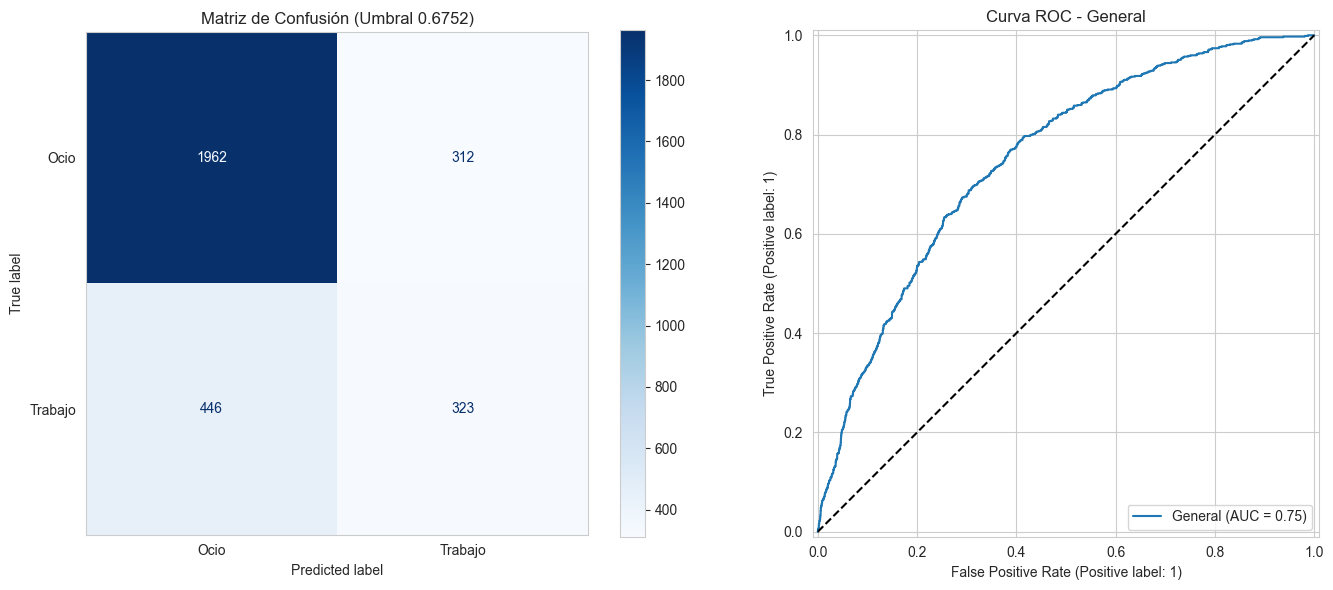

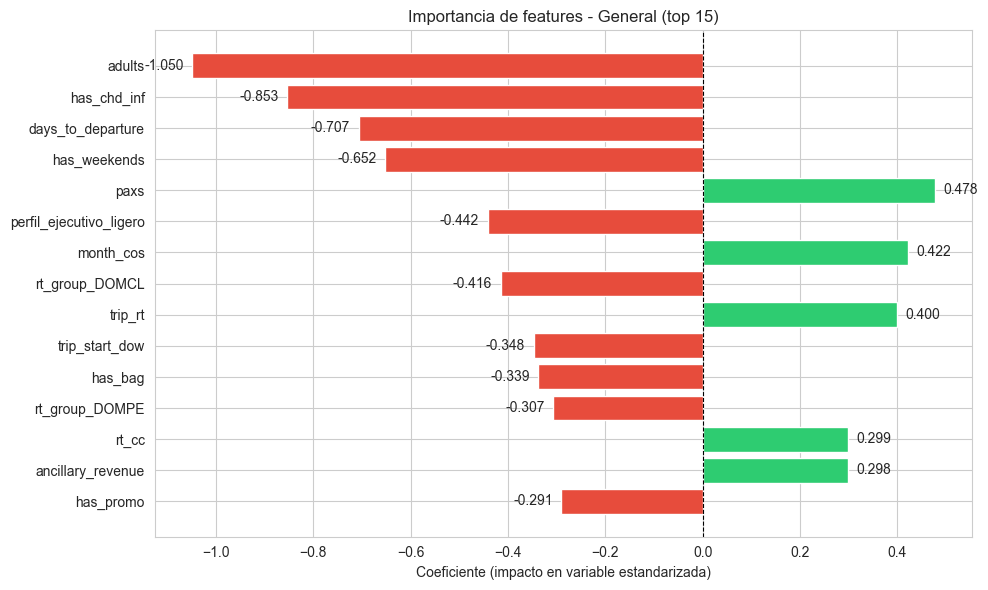

In [44]:
# --- Modelo General ---
print("Cargando datos para el Modelo General...")
X_train_gen = pd.read_parquet(f'{DATA_DIR}X_train_general_encoded.parquet')
X_test_gen = pd.read_parquet(f'{DATA_DIR}X_test_general_encoded.parquet')
y_train_gen = pd.read_pickle(f'{DATA_DIR}y_train_general.pkl')
y_test_gen = pd.read_pickle(f'{DATA_DIR}y_test_general.pkl')

modelo_general, metrics_general = entrenar_modelo_visual(
    X_train_gen, X_test_gen, y_train_gen, y_test_gen, "General", PARAMS_LR_GENERAL
)


Cargando datos para el Modelo Chile...
 PROCESANDO MODELO: CL
-> Aplicando SMOTE en CL...
-> Entrenando Regresión Logística (con Escalado estándar)...

--- RESULTADOS: CL ---
ROC-AUC: 0.8409
              precision    recall  f1-score   support

    Ocio (0)       0.80      0.88      0.84       298
 Trabajo (1)       0.72      0.58      0.64       159

    accuracy                           0.78       457
   macro avg       0.76      0.73      0.74       457
weighted avg       0.77      0.78      0.77       457



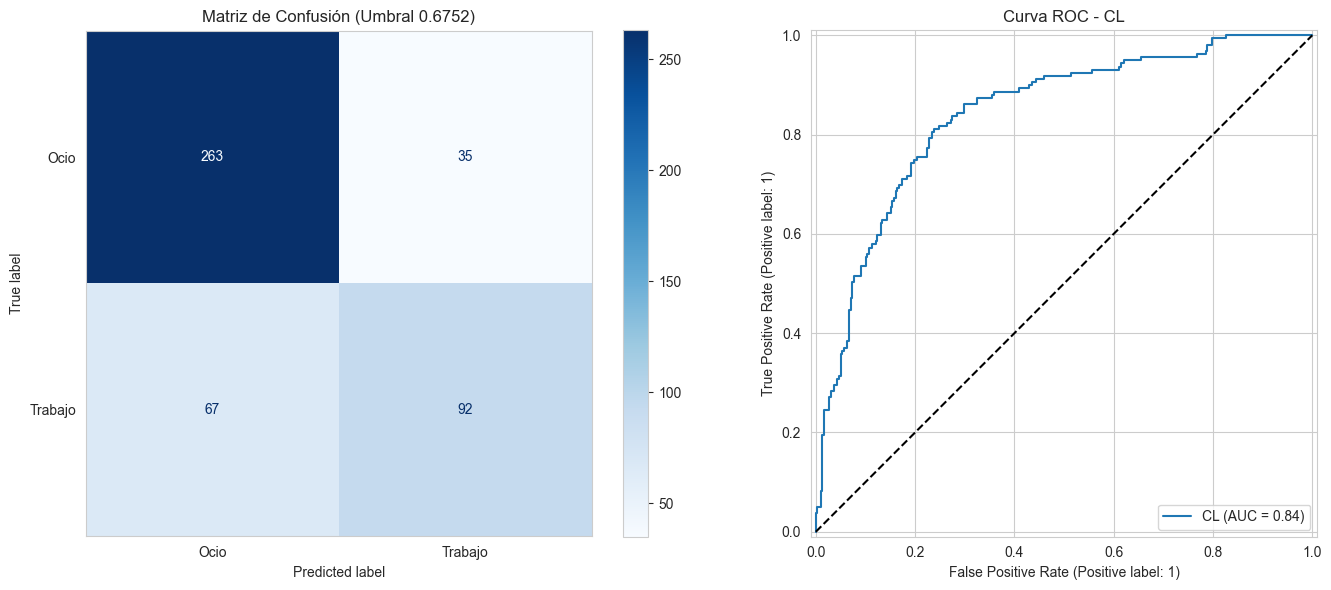

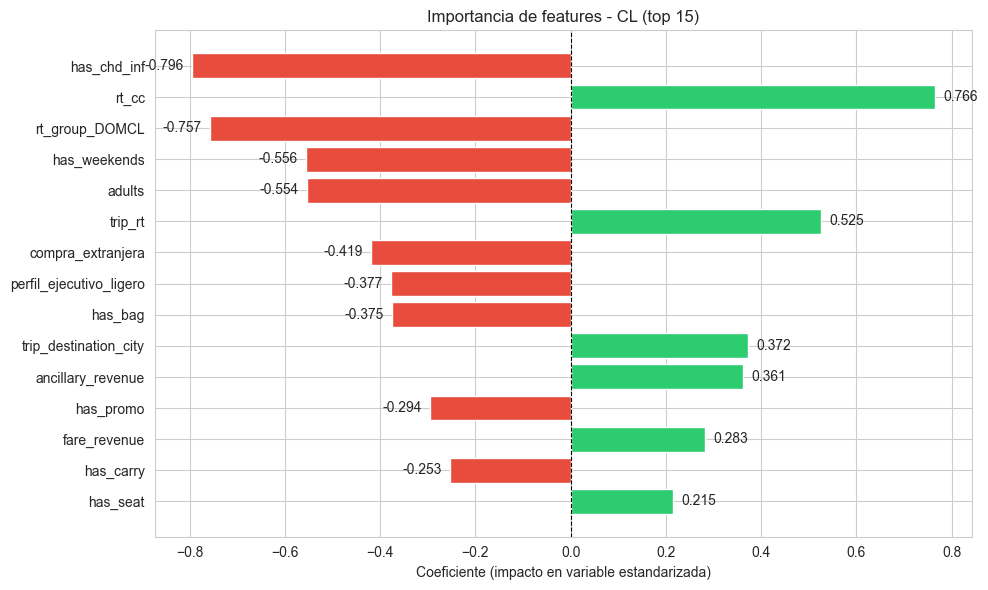

In [45]:
# --- Modelo Chile ---
print("Cargando datos para el Modelo Chile...")
X_train_CL = pd.read_parquet(f'{DATA_DIR}X_train_{MODELOCL}_encoded.parquet')
X_test_CL = pd.read_parquet(f'{DATA_DIR}X_test_{MODELOCL}_encoded.parquet')
y_train_CL = pd.read_pickle(f'{DATA_DIR}y_train_{MODELOCL}.pkl')
y_test_CL = pd.read_pickle(f'{DATA_DIR}y_test_{MODELOCL}.pkl')

modelo_chile, metrics_chile = entrenar_modelo_visual(
    X_train_CL, X_test_CL, y_train_CL, y_test_CL, MODELOCL, PARAMS_LR_CHILE
)


In [46]:
# # --- Modelo Inter ---
# print("Cargando datos para el Modelo Chile...")
# X_train_IN = pd.read_parquet(f'{DATA_DIR}X_train_{MODELOIN}_encoded.parquet')
# X_test_IN = pd.read_parquet(f'{DATA_DIR}X_test_{MODELOIN}_encoded.parquet')
# y_train_IN = pd.read_pickle(f'{DATA_DIR}y_train_{MODELOIN}.pkl')
# y_test_IN = pd.read_pickle(f'{DATA_DIR}y_test_{MODELOIN}.pkl')
#
# modelo_chile, metrics_chile = entrenar_modelo_visual(
#     X_train_IN, X_test_IN, y_train_IN, y_test_IN, MODELOIN, PARAMS_LR_GENERAL)

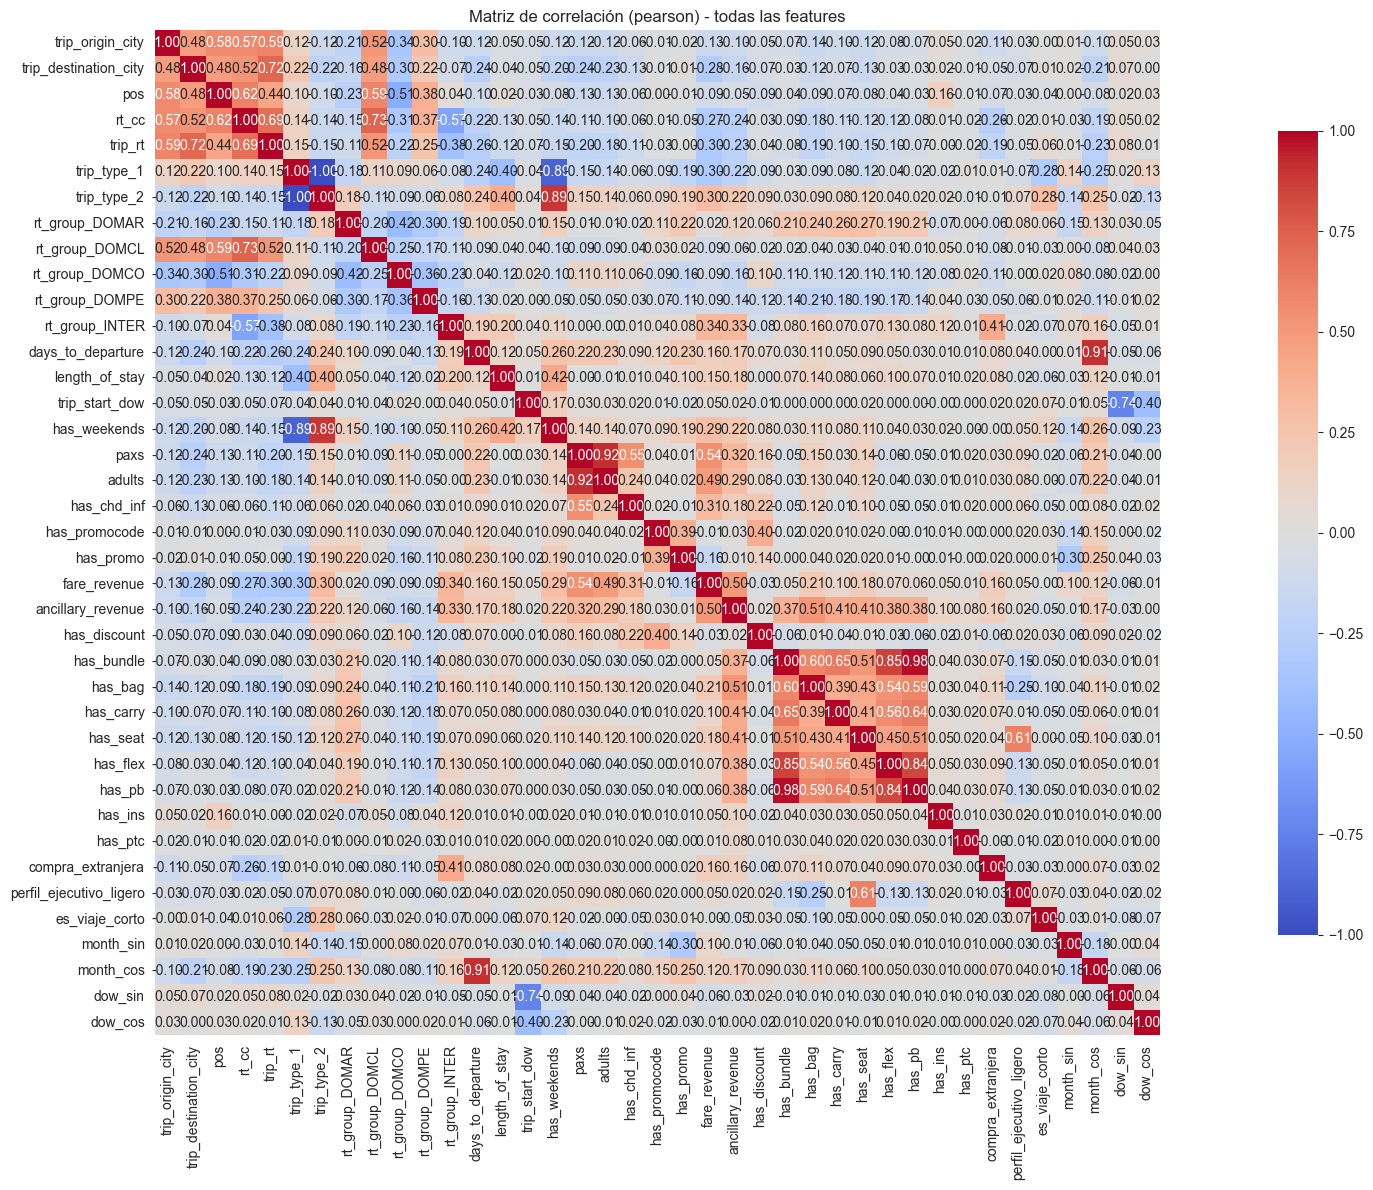

,trip_origin_city,trip_destination_city,pos,rt_cc,trip_rt,trip_type_1,trip_type_2,rt_group_DOMAR,rt_group_DOMCL,rt_group_DOMCO,rt_group_DOMPE,rt_group_INTER,days_to_departure,length_of_stay,trip_start_dow,has_weekends,paxs,adults,has_chd_inf,has_promocode,has_promo,fare_revenue,ancillary_revenue,has_discount,has_bundle,has_bag,has_carry,has_seat,has_flex,has_pb,has_ins,has_ptc,compra_extranjera,perfil_ejecutivo_ligero,es_viaje_corto,month_sin,month_cos,dow_sin,dow_cos
trip_origin_city,1.000000,0.481040,0.576132,0.571428,0.594519,0.123653,-0.123653,-0.208382,0.519201,-0.338929,0.302220,-0.102653,-0.115409,-0.045353,-0.054259,-0.115309,-0.122447,-0.118889,-0.061808,-0.011740,-0.016722,-0.126158,-0.104726,-0.048685,-0.070533,-0.137452,-0.095892,-0.117798,-0.076462,-0.066750,0.053934,-0.020379,-0.110896,-0.034913,-0.002710,0.010283,-0.095811,0.051596,0.026696
trip_destination_city,0.481040,1.000000,0.483996,0.524137,0.721757,0.215459,-0.215459,-0.158680,0.476791,-0.303271,0.217245,-0.072899,-0.235767,-0.036019,-0.051421,-0.197151,-0.237376,-0.226391,-0.130463,-0.011765,0.012686,-0.277480,-0.159550,-0.073555,-0.029429,-0.122867,-0.070549,-0.128978,-0.034843,-0.025946,0.019159,-0.007954,-0.046601,-0.066845,0.011113,0.019821,-0.213437,0.065256,0.001634
pos,0.576132,0.483996,1.000000,0.617076,0.439025,0.097165,-0.097165,-0.234436,0.591942,-0.511465,0.377398,0.035020,-0.098990,0.018045,-0.034211,-0.076568,-0.127087,-0.125425,-0.061259,0.004344,-0.008714,-0.089461,-0.053484,-0.091331,-0.036706,-0.092226,-0.071582,-0.084768,-0.040067,-0.032461,0.162176,-0.011362,-0.065493,-0.033095,-0.035874,0.003096,-0.075984,0.022793,0.029769
rt_cc,0.571428,0.524137,0.617076,1.000000,0.693962,0.140117,-0.140117,-0.145654,0.733911,-0.306178,0.370037,-0.567784,-0.217544,-0.130097,-0.050579,-0.136758,-0.107239,-0.102089,-0.059511,-0.011142,-0.047395,-0.274627,-0.242376,-0.032142,-0.085707,-0.177715,-0.109142,-0.122695,-0.120648,-0.082614,0.006543,-0.024975,-0.255304,-0.021297,0.006696,-0.033090,-0.185222,0.054854,0.019890
trip_rt,0.594519,0.721757,0.439025,0.693962,1.000000,0.148362,-0.148362,-0.106190,0.522205,-0.222908,0.253054,-0.377936,-0.260050,-0.119024,-0.068519,-0.152405,-0.195731,-0.184660,-0.114947,-0.028144,-0.002177,-0.303003,-0.227593,-0.035915,-0.075647,-0.191240,-0.102243,-0.148335,-0.098077,-0.071824,-0.004552,-0.015959,-0.190762,-0.046182,0.062351,0.008819,-0.232226,0.080654,0.006155
trip_type_1,0.123653,0.215459,0.097165,0.140117,0.148362,1.000000,-1.000000,-0.176580,0.112583,0.089293,0.060830,-0.082655,-0.241717,-0.395885,-0.043147,-0.891050,-0.146378,-0.144876,-0.063489,-0.090841,-0.187985,-0.302820,-0.216243,-0.094841,-0.025140,-0.085252,-0.076711,-0.121569,-0.041177,-0.024938,-0.023975,0.009145,0.006453,-0.073438,-0.284476,0.142333,-0.247549,0.019685,0.133232
trip_type_2,-0.123653,-0.215459,-0.097165,-0.140117,-0.148362,-1.000000,1.000000,0.176580,-0.112583,-0.089293,-0.060830,0.082655,0.241717,0.395885,0.043147,0.891050,0.146378,0.144876,0.063489,0.090841,0.187985,0.302820,0.216243,0.094841,0.025140,0.085252,0.076711,0.121569,0.041177,0.024938,0.023975,-0.009145,-0.006453,0.073438,0.284476,-0.142333,0.247549,-0.019685,-0.133232
rt_group_DOMAR,-0.208382,-0.158680,-0.234436,-0.145654,-0.106190,-0.176580,0.176580,1.000000,-0.202152,-0.420385,-0.298149,-0.190344,0.104168,0.047301,-0.012346,0.152772,-0.010590,-0.012594,-0.016138,0.106530,0.215725,0.017244,0.115131,0.059320,0.211676,0.235402,0.262377,0.270758,0.194373,0.209716,-0.068836,0.001390,-0.056425,0.076830,0.058467,-0.154557,0.131279,0.030407,-0.046672
rt_group_DOMCL,0.519201,0.476791,0.591942,0.733911,0.522205,0.112583,-0.112583,-0.202152,1.000000,-0.245637,-0.174213,-0.111221,-0.085604,-0.044545,-0.037949,-0.097944,-0.089907,-0.090645,-0.042495,0.033039,0.016123,-0.093612,-0.056822,-0.016099,-0.016247,-0.040603,-0.028607,-0.037219,-0.010353,-0.011404,0.048627,-0.007364,-0.076259,-0.007029,-0.029540,0.003441,-0.081848,0.043297,0.027889
rt_group_DOMCO,-0.338929,-0.303271,-0.511465

In [47]:
matriz_correlacion_por_modelo(modelo_general, X_train_gen)
